# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### logistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# 로지스틱회귀후에 .coef_ 항목에서 기준(criteria, 계수)보다 높은 영향력을 미치는 feature column 선택
def select_features(df, coef, criteria):
    sel_num = np.where(np.abs(coef) > criteria )[1]
    sel_col = df.columns[sel_num]
    return sel_col

In [3]:
def get_scores(data, target):
    train_input, test_input, train_target, test_target = train_test_split(data, target, random_state=42, test_size=0.2, stratify=target)

    ss = StandardScaler()
    ss.fit(train_input)
    train_scaled = ss.transform(train_input)
    test_scaled = ss.transform(test_input)

    lr = LogisticRegression(C=20, max_iter=4000) # max_iter default 100, 
#     lr = LogisticRegression(C=1, solver='newton_cg', max_iter=1000) # max_iter default 100, 
    lr.fit(train_scaled, train_target)

    train_score = lr.score(train_scaled, train_target)
    test_score = lr.score(test_scaled, test_target)
#     print(f'train score: {train_score:.4f} \n test score; {test_score:.4f}')
    return train_score, test_score, lr.coef_, lr.intercept_

In [4]:
def find_best_result(data, target):
# min을 하나씩 제거하면서 최고의 결과를 가져오는 feature갯수(항목) 선택

    train_score_list= []
    test_score_list = []
#     data_columns = []
#     data_coef = []
    test_s = 0
    train_score, test_score, coef, intercept = get_scores(data, target)
    for _ in range(len(data.columns)-1):
        criteria = np.abs(coef).min()
        sel_col = select_features(data, coef, criteria)
        data = df[sel_col]
        train_score, test_score, coef, intercept = get_scores(data, target)

        if test_score > test_s:
            test_s = test_score
            data_columns = sel_col
            data_coef = coef

        train_score_list.append(train_score)
        test_score_list.append(test_score)
    
    return train_score_list, test_score_list, data_columns, data_coef

In [378]:
# 분석용 데이터 입력
directory_for_ml = '../data/data_for_ml/'
fname = 'df_hyunmotor_sel.pkl'
f_name = directory_for_ml + fname
df = pd.read_pickle(f_name)
plt_title = fname[3:7]

In [380]:
data = df.iloc[:, :-5]


target = df.iloc[:, -5]
col_num = int(len(data.columns)/4)
data = data.iloc[:, :col_num]
target = target.apply(lambda x : 0 if ((x == 1) | (x ==2)) else 1 ) # 최고가 시간이 오후인 경우
# target = target.apply(lambda x : 0 if ((x == 1) | (x ==2)) else (1 if x == 3 else  2 ))
plt_title2 = '4classes'

# target = df.iloc[:, -1]
# plt_title2 = 'r_open_high_1'

# target = df.iloc[:, -2]
# plt_title2 = 'close_cr_1'

# target = df.iloc[:, -3]
# plt_title2 = 'r_open_high_5'

# target = df.iloc[:, -4]
# plt_title2 = 'close_cr_5'

In [381]:
data.head()

,retail,foreigner,institution,financial,invtrust,pension,privequity,bank,insurance
2022-06-21,-1.871152,-0.449573,-14.907420,0.221049,-1.023835,-2.375993,-1.012961,-0.985222,3.731884
2022-06-22,0.330579,-0.764360,-0.087759,-0.337681,52.944444,-1.179831,52.957143,4.166667,0.346095
2022-06-23,-0.506794,-7.212675,-1.123886,-1.100064,-0.447374,3.458716,-0.779719,43.387097,-0.441411
2022-06-24,1.838694,-1.298676,-12.660522,-21.170053,1.685799,-1.193158,-1.751202,-0.999273,-1.403259
2022-06-27,-0.008387,-5.176683,-0.595997,-0.312530,-0.941299,-4.874834,-2.712000,1735.000000,-5.348485


In [382]:
train_score_list, test_score_list, data_columns, data_coef = find_best_result(data, target)

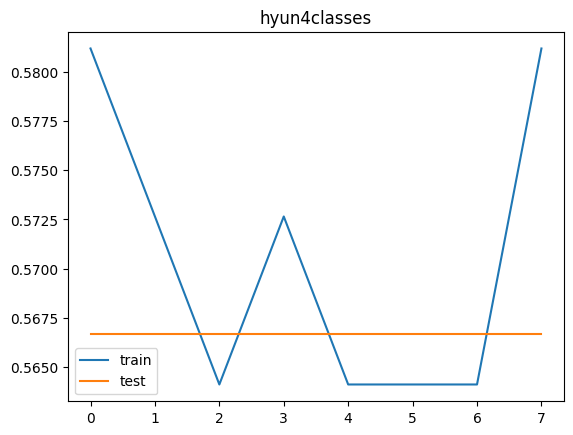

In [383]:
plt.plot(train_score_list, label = 'train')
plt.plot(test_score_list, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

In [384]:
print(data_columns, data_coef)
print("train_max: {:.4f}, test_max: {:.4f}".format(max(train_score_list), max(test_score_list)))

Index(['retail', 'foreigner', 'institution', 'financial', 'invtrust',
       'pension', 'bank', 'insurance'],
      dtype='object') [[ 0.15588811  0.17718233 -0.1314469   0.07361665 -0.12908296 -0.06408788
  -0.1797487  -0.83151132]]
train_max: 0.5812, test_max: 0.5667


In [385]:
data_columns.shape

(8,)

In [386]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, train_test_split
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [387]:
data_new = data[data_columns]
# target = df.iloc[:, -2]  # logistic regression에서 생성된 target을 그대로 사용

In [388]:
data_new.tail()

,retail,foreigner,institution,financial,invtrust,pension,bank,insurance
2023-02-21,-1.041371,-1.419698,-1.883598,-1.282641,-0.857143,3.213364,-1.205607,-0.632461
2023-02-22,-0.789130,-1.943003,-1.910111,-3.125776,6.982609,-0.973509,-1.136364,-0.447293
2023-02-23,140.412371,-0.484018,1.311842,1.236668,1.465142,2.741497,0.333333,-3.814433
2023-02-24,-2.368375,4.024453,-0.865833,-1.235124,0.210782,-8.007273,-1.250000,0.578755
2023-02-27,-1.394459,-1.243940,-0.777640,-1.869959,-0.733577,-1.472496,-70.000000,-1.259861


In [389]:
train_input, test_input, train_target, test_target = train_test_split(data_new, target, random_state=42, test_size=0.2, stratify=target)

In [390]:
print(train_input.shape, train_target.shape)

(117, 8) (117,)


In [391]:
np.unique(train_target, return_counts=True)

(array([0, 1], dtype=int64), array([65, 52], dtype=int64))

In [392]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [393]:
value = []
for iter in range(5, 50, 1):
    sc = SGDClassifier(loss='log', max_iter=iter, random_state=42)
#     sc = SGDClassifier(max_iter=iter, random_state=42)
    scores = cross_validate(sc,
                            X=train_scaled, y=train_target,
                            n_jobs=-1)
#     print(scores['test_score'].mean())
    value.append(scores['test_score'].mean())

In [394]:
print("max", max(value))

max 0.547463768115942


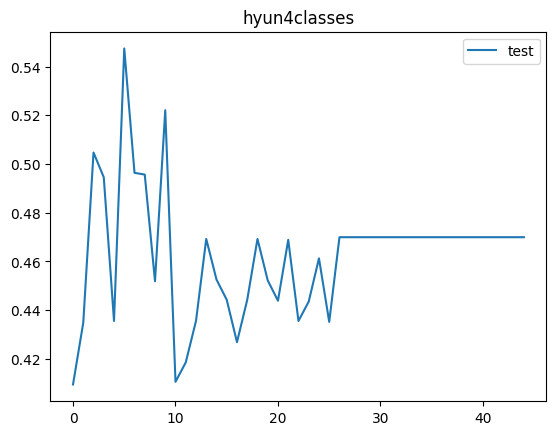

In [395]:
plt.plot(value, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

### 인공신경망

In [396]:
def model_fn(inp_num, a_layer=None):
    model = Sequential()
    model.add(Dense(12, activation='sigmoid', input_shape=(inp_num,)))
#     model.add(Dropout(0.1))
    model.add(Dense(6, activation='sigmoid'))
#     model.add(Dropout(0.1))
    if a_layer:
        model.add(a_layer)
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [397]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
try :
    del model
    print("delete del")
except:
    pass
model = model_fn(len(data_new.columns))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

delete del
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 12)                108       
                                                                 
 dense_34 (Dense)            (None, 6)                 78        
                                                                 
 dense_35 (Dense)            (None, 1)                 7         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [398]:
# checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5', \
#                                                 monitor='val_accuracy', mode='max', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_accuracy', mode='max', restore_best_weights=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_loss', mode='min', restore_best_weights=True)

In [399]:
np.unique(train_target), np.unique(test_target)

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

In [400]:
history = model.fit(train_scaled, train_target, epochs=2000, verbose=0,
                    callbacks=[checkpoint_cb, earlystopping_cb],
                    validation_data=(test_scaled, test_target))
# batch_size=

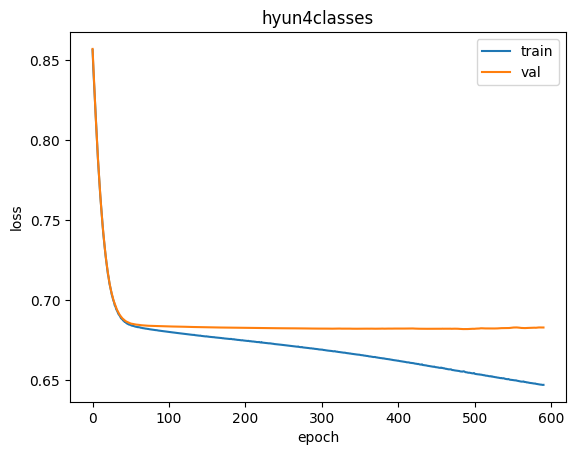

In [401]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title(plt_title+plt_title2)
plt.show()

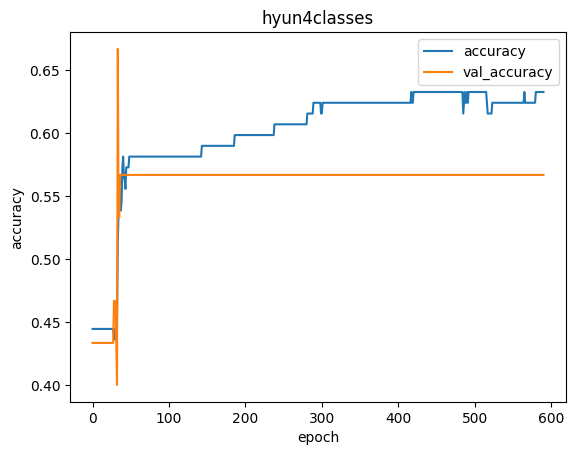

In [402]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title(plt_title+plt_title2)
plt.show()

In [403]:
earlystopping_cb.stopped_epoch

590

In [404]:
model.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 16ms/step - loss: 0.6818 - accuracy: 0.5667


[0.6817620396614075, 0.5666666626930237]

In [405]:
model_val = load_model('best_model.h5')
model_val.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 80ms/step - loss: 0.6818 - accuracy: 0.5667


[0.6817620396614075, 0.5666666626930237]

In [406]:
y_predict = model.predict(np.array(test_scaled))

1/1 [==============================] - 0s 38ms/step


In [407]:
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]

In [408]:
compare = [ [x, y] for x, y in zip(test_target, y_predict)]
# compare = [ [x, y] for x, y in zip(test_target, y_predict_list)]
compare # 실제값. 예측값

[[1, array([0.4477776], dtype=float32)],
 [0, array([0.4298193], dtype=float32)],
 [1, array([0.43996903], dtype=float32)],
 [0, array([0.4368503], dtype=float32)],
 [1, array([0.4250639], dtype=float32)],
 [0, array([0.39553714], dtype=float32)],
 [0, array([0.42202803], dtype=float32)],
 [0, array([0.431656], dtype=float32)],
 [1, array([0.4000078], dtype=float32)],
 [1, array([0.4353414], dtype=float32)],
 [0, array([0.3680374], dtype=float32)],
 [0, array([0.42222053], dtype=float32)],
 [0, array([0.42897874], dtype=float32)],
 [0, array([0.42448083], dtype=float32)],
 [1, array([0.43365282], dtype=float32)],
 [0, array([0.4366086], dtype=float32)],
 [1, array([0.42055258], dtype=float32)],
 [0, array([0.44438824], dtype=float32)],
 [1, array([0.43362045], dtype=float32)],
 [0, array([0.4344985], dtype=float32)],
 [0, array([0.43687084], dtype=float32)],
 [1, array([0.43302998], dtype=float32)],
 [0, array([0.4329904], dtype=float32)],
 [0, array([0.42637607], dtype=float32)],
 [0,

In [409]:
from sklearn.metrics import precision_score, recall_score
# 정밀도 : 양성으로 예측된 것(TP+FP) 중 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
precision_score(test_target, y_predict_list)  # 정밀도, 입력값의 순서 중요힘. (실제값, 예측값)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [410]:
# 재현율 : 전체 양성 샘플(TP+FN) 중에서 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
recall_score(test_target, y_predict_list)  # 재현율, 입력값의 순서 중요힘. (실제값, 예측값)

0.0

In [411]:
from sklearn.metrics import f1_score

f1_score(test_target, y_predict_list)

0.0

In [412]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_target, y_predict_list)

array([[17,  0],
       [13,  0]], dtype=int64)

In [413]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_target, y_predict_list)

0.5

1. 정밀도, f1-score, 
2. confusion matrix ((1,1), (2,2), 두개가 큰 비중이면 good, (2,1)은 진을 부로 구분, (1,2)는 부를 진으로 결정하는 항목) "ㄴ" 형태
    (2,2) -> (1,1) -> (2,1)로 확인. (1,2)가 크면 모델 제외
    
<img src="https://raw.githubusercontent.com/fasthill/My-gist/main/data/picture/confusion_matrix.png" width="800"/> <br>

In [41]:
for innum in range(30):
    aa = np.array([test_scaled[innum]])
    y_predict = model.predict(aa)
#     print("predict: {},  target_value: {}".format(y_predict, test_target[innum]))

1/1 [==============================] - 0s 15ms/step


In [ ]:
### ROC 확인해 봐야 함. 정확도, 정밀도 등

In [ ]:
'''
model.save('my_model.h5')
model_new = load_model('my_model.h5')
model_new.evaluate(test_scaled, test_target)
'''

수수료: 주식거래수수료 0.015%. 유관기관수수료 0.0036%, 증권거래세 0.08, 농어촌 특별세 0.15%
수수료 : (0.015+0.0036 ) * 2 (사고팔때), 증권거래세 : 0.08 + 0.15 (팔때)
전체 지출 금액율: 0.2672%